In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

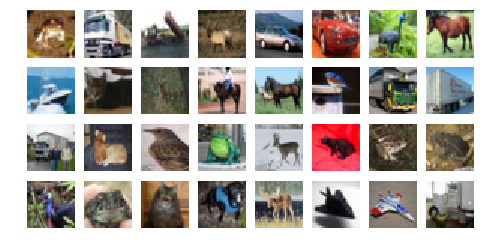

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

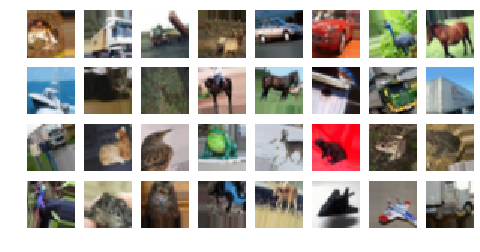

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

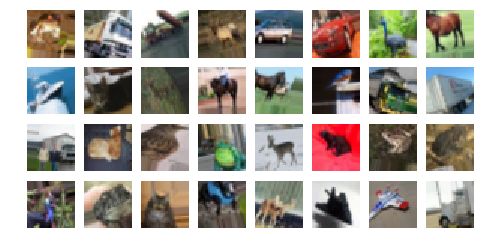

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果